In [17]:
import xarray as xr
from pathlib import Path
from typing import List, Dict, Tuple, NamedTuple, Iterable, Hashable
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpy as np
import cartopy.crs as ccrs
from tqdm import tqdm
from plotting import date_to_processed, processed_to_date, measures_to_date, cmems_to_date, bin_ndarray, rotate_data, make_png

In [18]:
def cmems_to_same_format(cmems: xr.Dataset) -> npt.NDArray[np.float64]:
    new_cmems = rotate_data(cmems.sla[0], 'longitude', 180)
    new_shape = (180, 360)
    return bin_ndarray(new_cmems, new_shape, operation='mean')

def measures_to_same_format(measures: xr.Dataset) -> npt.NDArray[np.float64]:
    new_measures = rotate_data(measures.SLA[0], 'Longitude', 180)
    new_shape = (160, 360)
    binned_measures = bin_ndarray(new_measures, new_shape, operation='mean')
    return np.pad(binned_measures, ((10, 10), (0,0)), mode='constant', constant_values=(np.nan,))

In [29]:
CMEMS_PATHS = [
    Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\CMEMS"),
    Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\CMEMS_2019_old"),
]
MEASURES_PATH = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\MEaSUREs")
PROCESSED = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\Processed_v4_v10")

# main = PROCESSED
# main_glob = '*.nc'
# main_name = "Project"
# main_to_date = processed_to_date
# main_to_same_format = lambda x: x.sla.data
# compare_dataset = CMEMS_PATHS
# compare_to_date = cmems_to_date
# to_same_format = cmems_to_same_format
# reference_name = "CMEMS"
# glob = 'dt_global_allsat_phy_l4_*.nc'

# main = PROCESSED
# main_glob = '*.nc'
# main_name = "Project"
# main_to_date = processed_to_date
# main_to_same_format = lambda x: x.sla.data
# compare_dataset = MEASURES_PATH
# compare_to_date = measures_to_date
# to_same_format = measures_to_same_format
# reference_name = "MEaSUREs"
# glob = "*.nc"

main = CMEMS_PATHS
main_name = "CMEMS"
main_glob = 'dt_global_allsat_phy_l4_*.nc'
main_to_date = cmems_to_date
main_to_same_format = cmems_to_same_format
compare_dataset = MEASURES_PATH
compare_to_date = measures_to_date
to_same_format = measures_to_same_format
reference_name = "MEaSUREs"
glob = "*.nc"

In [30]:
def get_paths(paths: List[Path] | Path, glob: str) -> List[Path]:
    if isinstance(paths, Path):
        return list(paths.glob(glob))
    out_paths = []
    for path in paths:
        out_paths.extend(path.glob(glob))
    return out_paths
reference_files = get_paths(compare_dataset, glob)
reference_dates = [compare_to_date(f) for f in reference_files]
mapped_files = []
mapped_dates = []

In [5]:
files = []
for file in tqdm(get_paths(main, main_glob)):
    file_date = main_to_date(file)
    if file_date in mapped_dates:
        continue
    if file_date in reference_dates:
        reference_file = reference_files[reference_dates.index(file_date)]
        with xr.open_dataset(reference_file) as ref:
            reference_matrix = to_same_format(ref)
        with xr.open_dataset(file) as ours:
            data = main_to_same_format(ours)
        mapped_files.append(data - reference_matrix)
        mapped_dates.append(file_date)

100%|██████████| 10963/10963 [43:54<00:00,  4.16it/s]  


In [6]:
sorted_diff = [x for _, x in sorted(zip(mapped_dates, mapped_files), key=lambda pair: pair[0])]

In [7]:
stacked_diff = np.stack(sorted_diff)
staked_dates = np.array(mapped_dates)

In [8]:
with open(f'stacked_diff_{main_name}_{reference_name}.npy', 'wb') as f:
    np.save(f, stacked_diff)
with open(f'staked_dates_{main_name}_{reference_name}.npy', 'wb') as f:
    np.save(f, staked_dates)

In [31]:
with open(f'stacked_diff_{main_name}_{reference_name}.npy', 'rb') as f:
    stacked_diff = np.load(f)
with open(f'staked_dates_{main_name}_{reference_name}.npy', 'rb') as f:
    staked_dates = np.load(f, allow_pickle=True)

In [32]:
mean_diff = np.nanmean(stacked_diff, axis=0)
std_diff = np.nanstd(stacked_diff, axis=0)

C:\Users\Casper\AppData\Local\Temp\ipykernel_6920\4224296108.py:1: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(stacked_diff, axis=0)


In [33]:
output_folder = Path("CompTimeSeries")
make_png(
    image = (mean_diff - np.nanmean(mean_diff))*100,
    figsize = (13, 6),
    output_path = output_folder / f"{main_name}_{reference_name}_mean.png",
    extent = [-180, 180, -90, 90],
    vmin = -5,
    vmax = 5,
    title = f"Mean difference ({main_name} - {reference_name})",
    cbar_label = "SLA [cm]",
    fontsize = 17,
    ticksize = 15,
    titlesize = 20
)

make_png(
    image = std_diff*100,
    figsize = (13, 6),
    output_path = output_folder / f"{main_name}_{reference_name}_std.png",
    extent = [-180, 180, -90, 90],
    vmin = 0,
    vmax = 15,
    title = f"Standard deviation of the difference\n({main_name} - {reference_name})",
    cbar_label = "SLA [cm]",
    fontsize = 17,
    ticksize = 15,
    titlesize = 20
)

In [34]:
after_date = staked_dates >= date(2000, 1, 1)
mean_diff_after_date = np.nanmean(stacked_diff[after_date], axis=0)
std_diff_after_date = np.nanstd(stacked_diff[after_date], axis=0)

C:\Users\Casper\AppData\Local\Temp\ipykernel_6920\72009609.py:2: RuntimeWarning: Mean of empty slice
  mean_diff_after_date = np.nanmean(stacked_diff[after_date], axis=0)


In [35]:
output_folder = Path("CompTimeSeries")
make_png(
    image = (mean_diff_after_date - np.nanmean(mean_diff_after_date)) * 100,
    figsize = (13, 6),
    output_path = output_folder / f"{main_name}_{reference_name}_mean_2000.png",
    extent = [-180, 180, -90, 90],
    vmin = -5,
    vmax = 5,
    title = f"Mean difference ({main_name} - {reference_name}, since 2000)",
    cbar_label = "SLA [cm]",
    fontsize = 17,
    ticksize = 15,
    titlesize = 20,
    cmap='jet'
)

make_png(
    image = std_diff_after_date * 100,
    figsize = (13, 6),
    output_path = output_folder / f"{main_name}_{reference_name}_std_2000.png",
    extent = [-180, 180, -90, 90],
    vmin = 0,
    vmax = 15,
    title = f"Standard deviation of the difference\n({main_name} - {reference_name}, since 2000)",
    cbar_label = "SLA [cm]",
    fontsize = 17,
    ticksize = 15,
    titlesize = 20,
    cmap='jet'
)

In [36]:
print(f"{main_name} - {reference_name}")
print(f"mean = {np.nanmean(mean_diff_after_date) * 100:.2f} cm")
print(f"std = {np.nanmean(std_diff_after_date) * 100:.2f} cm")

CMEMS - MEaSUREs
mean = 1.85 cm
std = 2.48 cm


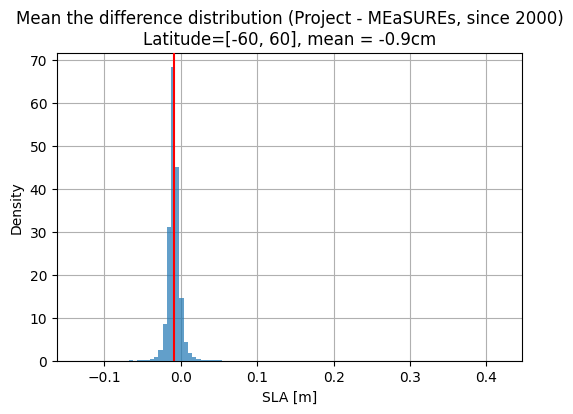

In [31]:
remove_deg = 30
flatten_mean = mean_diff_after_date[remove_deg:-remove_deg, :].flatten()
plt.figure(figsize=(6,4))
plt.hist(flatten_mean, density=True, alpha=0.7, bins=100, zorder=5)
plt.axvline(np.nanmean(flatten_mean), color='red', zorder=6)
plt.grid(zorder=1)
plt.title(f"Mean the difference distribution ({main_name} - {reference_name}, since 2000)\nLatitude=[{remove_deg - 90}, {90 - remove_deg}], mean = {np.nanmean(flatten_mean)*100:.1f}cm")
plt.ylabel("Density")
plt.xlabel("SLA [m]")
plt.savefig(output_folder / f"{main_name}_{reference_name}_mean_distribution_2000.png",)
plt.show()

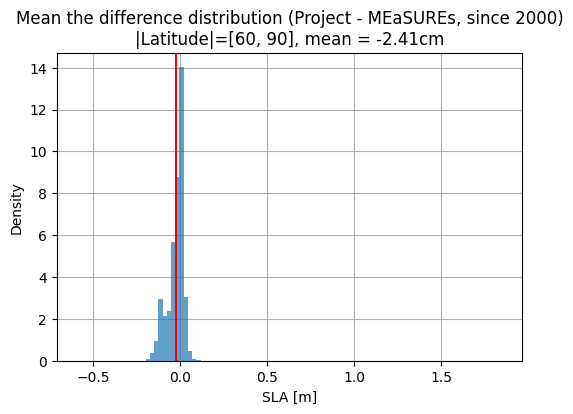

In [32]:
remove_deg = 30
flatten_mean = np.stack([mean_diff_after_date[:remove_deg,:], mean_diff_after_date[-remove_deg:,:]]).flatten()
plt.figure(figsize=(6,4))
plt.hist(flatten_mean, density=True, alpha=0.7, bins=100, zorder=5)
plt.axvline(np.nanmean(flatten_mean), color='red', zorder=6)
plt.grid(zorder=1)
plt.title(f"Mean the difference distribution ({main_name} - {reference_name}, since 2000)\n|Latitude|=[{90 - remove_deg}, 90], mean = {np.nanmean(flatten_mean)*100:.2f}cm")
plt.ylabel("Density")
plt.xlabel("SLA [m]")
plt.savefig(output_folder / f"{main_name}_{reference_name}_mean_polar_distribution_2000.png",)
plt.show()

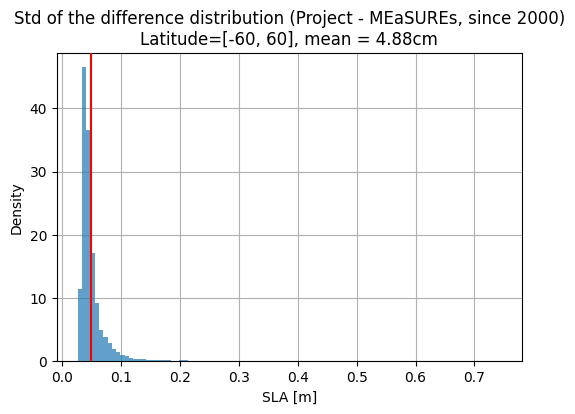

In [33]:
remove_deg = 30
flatten_std = std_diff_after_date[remove_deg:-remove_deg, :].flatten()
plt.figure(figsize=(6,4))
plt.hist(flatten_std, density=True, alpha=0.7, bins=100, zorder=5)
plt.axvline(np.nanmean(flatten_std), color='red', zorder=6)
plt.grid(zorder=1)
plt.title(f"Std of the difference distribution ({main_name} - {reference_name}, since 2000)\nLatitude=[{remove_deg - 90}, {90 - remove_deg}], mean = {np.nanmean(flatten_std)*100:.2f}cm")
plt.ylabel("Density")
plt.xlabel("SLA [m]")
plt.savefig(output_folder / f"{main_name}_{reference_name}_std_distribution_2000.png",)
plt.show()